In [9]:
import torch,os,cv2,csv
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
from skimage import io, transform
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import Linear, ReLU,Tanh, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip -q "/content/drive/My Drive/CelebA.zip" 

In [0]:
class CustomDataset(Dataset):

    def __init__(self, csv_file, root_dir, transform=None):
        
        self.attributes_frame = pd.read_csv(csv_file,delimiter=' ')
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.attributes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.attributes_frame.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.resize(image,(64,64))
        attributes = self.attributes_frame.loc[idx, ['Male','Eyeglasses','Smiling']]
        attributes = np.array([attributes])
        attributes = attributes.astype('float').reshape(-1, 1)
        sample = {'image': image, 'attributes': attributes}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [0]:
class ToTensor(object):
    def __call__(self, sample):
        image, attributes = sample['image'], sample['attributes']
        norm_image  = image
        
        norm_image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        im = torch.from_numpy(norm_image).float()
        ln = torch.from_numpy(attributes).float()
        return {'image':im,
                'attributes':ln }

In [0]:
imgpath = '/content/img_align_celeba'
attrfile = '/content/processed_file.txt'
BATCH_SIZE = 128

dataset = CustomDataset(csv_file=attrfile,root_dir=imgpath,transform=transforms.Compose([
                                               ToTensor()
                                           ]))

validation_split = .006
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_iterator = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, 
                                           sampler=train_sampler)
test_iterator = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                                sampler=valid_sampler)

In [14]:
print(len(test_iterator))

for i, sample in enumerate(test_iterator):
  print(sample['image'].shape,sample['attributes'].shape)
  break

10
torch.Size([128, 64, 64, 3]) torch.Size([128, 3, 1])


In [0]:

import torch.nn as nn
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, n_classes):
        super().__init__()
        
        self.cnn_layers = Sequential(
            # 3x 64 x 64 => 64 x 32 x 32
            Conv2d(3, 64, kernel_size=5, stride=2, padding=2),
            ReLU(inplace=True),
  
#             32 x 32 --> 16 x 16
            Conv2d(64, 128, kernel_size=5, stride=2, padding=2),
            BatchNorm2d(128),
            ReLU(inplace=True),

#             16 x 16 --> 8 x 8
            Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(inplace=True),
#             8 x 8 --> 4 x 4

            Conv2d(256, 256 ,kernel_size=3, stride=2, padding=1),
            BatchNorm2d(256),
            ReLU(inplace=True),
#             4 x 4 --> 1 x 1
            Conv2d(256, 1024 ,kernel_size=4, stride=1, padding=0),
            
            ReLU(inplace=True),
        )

        self.linear = nn.Linear(1024, 1024)
        self.drop_layer = nn.Dropout(0.5)
        
        self.linearzim = nn.Linear(1027,512)
        
        self.mu = nn.Linear(512, latent_dim)
        self.var = nn.Linear(512, latent_dim)

    def forward(self, x,y):
        
        cnn_x = self.cnn_layers(x)
        cnn_x = cnn_x.view(y.shape[0],-1)
        z = F.relu(self.linear(cnn_x))
        z = self.drop_layer(z)
        # print(z.shape,y.shape)
        zim = torch.cat((z, y), dim=1)
        # print(zim.shape)
        hidden = F.relu(self.linearzim(zim))
  
        mean = self.mu(hidden)
        
        log_var = self.var(hidden)
        
        return mean, log_var

In [0]:
class Decoder(nn.Module):
   
    def __init__(self, latent_dim, output_dim, n_classes):
       
        super().__init__()
       
        self.linearz = nn.Linear(103, 256)
        self.linearz2 = nn.Linear(256, 1024*1*1)
        
        self.cnn_layers = Sequential(
            #  1 x 1 --> 4 x 4 
            nn.ConvTranspose2d(1024, 256 ,kernel_size=4, stride=1, padding=0),
            ReLU(inplace=True),

            #   4 x 4 --> 8 x 8
            nn.ConvTranspose2d(256, 256 ,kernel_size=4, stride=2, padding=1),
            ReLU(inplace=True),

            #   8 x 8 -->  16 x 16
            nn.ConvTranspose2d(256,128, kernel_size=4, stride=2, padding=1),
            ReLU(inplace=True),

            #  16 x 16  --> 32 x 32
            nn.ConvTranspose2d(128,64, kernel_size=4, stride=2, padding=1),
            ReLU(inplace=True),

#           64 x 32 x 32 => 3x 64 x 64
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()   
        )
    
    def forward(self, z,y):
        # print(z.shape,y.shape)
        z = torch.cat((z, y), dim=1)
        z = F.relu(self.linearz(z))
        
        z = F.relu(self.linearz2(z))
        z = z.view((-1,1024,1,1))
        
        generated_x = self.cnn_layers(z)

        generated_x = generated_x.view((-1, 3,64,64))
        return generated_x




In [0]:
class CVAE(nn.Module):
    
    def __init__(self, input_dim, latent_dim, n_classes):  
        super().__init__()

        self.encoder = Encoder(input_dim,  latent_dim, n_classes)
        self.decoder = Decoder(latent_dim, input_dim, n_classes)

    def forward(self, x, y):
        # print(x.shape,y.shape)
        # torch.Size([64, 3, 64, 64]) torch.Size([64, 73])
        z_mu, z_var = self.encoder(x,y)
        std = torch.exp(z_var / 2)
        eps = torch.randn_like(std)
        x_sample = eps.mul(std).add_(z_mu)
#         print("samplle: ",x_sample.shape)
        generated_x = self.decoder(x_sample,y)
        return generated_x, z_mu, z_var


In [65]:
INPUT_DIM = 64*64*3    
LATENT_DIM = 100        
N_CLASSES = 40  
lr = 0.001
model = CVAE(INPUT_DIM, LATENT_DIM, N_CLASSES).to(device)
#optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
model

CVAE(
  (encoder): Encoder(
    (cnn_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 1024, kernel_size=(4, 4), stride=(1, 1))
      (12): ReLU(inplace=True)
    )
    (linear): Linear(in_features=1024, out_features=1024, bias=True)
    (drop_layer): Dropout(p=0.5, inplace=False)
    (linearzim

In [0]:
def calculate_loss(reconstructed_x,x, mean, log_var):
    loss = nn.BCELoss().to(device)
    RCL = loss(reconstructed_x, x).to(device)
    
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # print("calculate loss ",RCL.item(),KLD.item())
    return  KLD + RCL


In [0]:
def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

def plot_each_iterate(original_images,rect_images,epoch):
  path = '/content/save image/'
  plt.figure(figsize=(10,5))
  for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(original_images[i])
    plt.subplot(2,5,i+6)
    plt.imshow(rect_images[i])

  for i in range(5):
    original_images[i] = cv2.cvtColor(original_images[i].numpy()*255 ,cv2.COLOR_BGR2RGB)
    rect_images[i] = cv2.cvtColor(rect_images[i].numpy()*255 ,cv2.COLOR_BGR2RGB)
   
  im_tile = concat_tile([original_images,rect_images])
  cv2.imwrite(path+str(epoch)+'.jpg', im_tile)  

In [0]:
import time
def train(model, device, train_iterator, optimizer, epoch, log_interval):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_iterator):
        x,y = data['image'],data['attributes']
        
        x = x.view(-1,3,64,64)
        x = x.to(device)
        y = y.view(-1,3)
        y = y.to(device)

        optimizer.zero_grad()
        reconstructed_x, z_mu, z_var = model(x, y)
        loss = calculate_loss( reconstructed_x,x, z_mu, z_var)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()), epoch, batch_idx * len(data),
                len(train_iterator.dataset), 100. * batch_idx / len(train_iterator), loss.item()))

    train_loss /= len(train_iterator)
    print('Train set Average loss:', train_loss)
    return train_loss

In [0]:

def test(model, device, test_loader,epoch):
    original_images = []
    rect_images = []
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, data in enumerate(train_iterator):
            x,y = data['image'],data['attributes']
            
            x = x.view(-1,3,64,64)
            x = x.to(device)
            y = y.view(-1,3)
            y = y.to(device)
            
            reconstructed_x, z_mu, z_var = model(x, y)
            loss = calculate_loss( reconstructed_x,x, z_mu, z_var)
            test_loss += loss.item()
            original_images.append(x[0].view((64,64,3)).cpu())
            rect_images.append(reconstructed_x[0].view((64,64,3)).cpu())
            if batch_idx == 4:
              plot_each_iterate(original_images,rect_images,epoch)
              break

    test_loss /= len(test_loader)
    print('Test set Average loss:', test_loss)

In [70]:
EPOCHS = 1
LATENT_SIZE = 100
PRINT_INTERVAL = 100
for epoch in range(EPOCHS):
        train_loss = train(model, device, train_iterator, optimizer, epoch, PRINT_INTERVAL)
        test(model, device, test_loader,epoch)

Fri Mar  6 08:35:58 2020 Train Epoch: 0 [0/202599 (0%)]	Loss: 25.451933
Fri Mar  6 08:36:48 2020 Train Epoch: 0 [200/202599 (6%)]	Loss: 0.703722
Fri Mar  6 08:37:38 2020 Train Epoch: 0 [400/202599 (13%)]	Loss: 0.676926
Fri Mar  6 08:38:28 2020 Train Epoch: 0 [600/202599 (19%)]	Loss: 0.667001
Fri Mar  6 08:39:18 2020 Train Epoch: 0 [800/202599 (25%)]	Loss: 0.664715
Fri Mar  6 08:40:08 2020 Train Epoch: 0 [1000/202599 (32%)]	Loss: 0.666182
Fri Mar  6 08:40:58 2020 Train Epoch: 0 [1200/202599 (38%)]	Loss: 0.665933
Fri Mar  6 08:41:48 2020 Train Epoch: 0 [1400/202599 (44%)]	Loss: 0.657006
Fri Mar  6 08:42:37 2020 Train Epoch: 0 [1600/202599 (51%)]	Loss: 0.663656
Fri Mar  6 08:43:26 2020 Train Epoch: 0 [1800/202599 (57%)]	Loss: 0.660918
Fri Mar  6 08:44:16 2020 Train Epoch: 0 [2000/202599 (64%)]	Loss: 0.663421
Fri Mar  6 08:45:05 2020 Train Epoch: 0 [2200/202599 (70%)]	Loss: 0.663601
Fri Mar  6 08:45:55 2020 Train Epoch: 0 [2400/202599 (76%)]	Loss: 0.667798
Fri Mar  6 08:46:44 2020 Train Ep

NameError: ignored

Test set Average loss: 0.3316661477088928


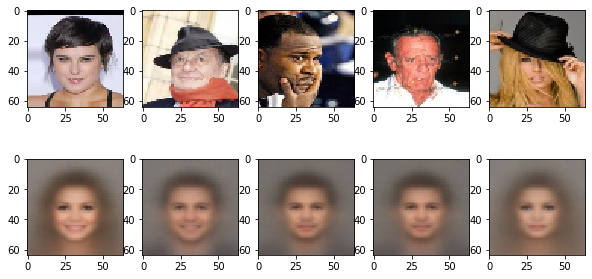

In [75]:
test(model, device, test_iterator,1)

[[ 1  1 -1]]


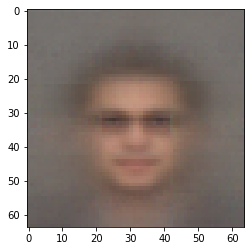

In [79]:
from random import seed
from random import choice

sequence = [-1,1]
data=[]
for _ in range(3):
	selection = choice(sequence)
	data.append(selection)

p = np.array(data).reshape(1,3)
print(p)
p = torch.from_numpy(p).float().to(device)
latent = torch.randn(1,100).to(device)
reconstructed_img = model.decoder(latent,p)
img = reconstructed_img.view(64, 64,3).cpu()
k = img.detach().numpy()
plt.imshow(k)

In [0]:
['Male','Eyeglasses','Smiling']

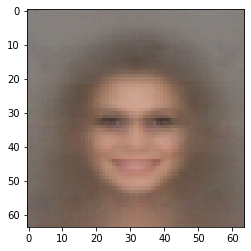

In [101]:
p = np.array([-1,1,1]).reshape(1,3)
p = torch.from_numpy(p).float().to(device)
latent = torch.randn(1,100).to(device)
reconstructed_img = model.decoder(latent,p)
img = reconstructed_img.view(64, 64,3).cpu()
k = img.detach().numpy()
plt.imshow(k)